In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import Can_Algorithms as alg
import numpy as nmp
import logging as log
import datetime
import os
import umap
import seaborn as sns  # for visualizing the confusion matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from scipy.interpolate import interp1d
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from appconfig import Config
from sklearn.feature_selection import RFE
import itertools
from tabulate import tabulate
from imblearn.over_sampling import SMOTE

In [17]:
# Initialize Config with the environment ('dev' or 'prod') and get Configuration value
appconfig = Config('prod')
log_folder=appconfig.getconfig_from_key("log_folder")
log_filename=appconfig.getconfig_from_key("log_filename")
datasets=appconfig.getconfig_from_key("datasets")
train_models=appconfig.getconfig_from_key("train_models")

# Configure logging to save log file in the folder
os.makedirs(log_folder, exist_ok=True)
log_file = os.path.join(log_folder, log_filename)
log.basicConfig(filename=log_file,
                level=log.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [18]:
def label_encode(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df[col] = label_encoder.fit_transform(df[col])

#Function to convert hex string to integer
def hex_to_int(x):
    if isinstance(x, str):
        try:
            return int(x, 16)
        except ValueError:
            return nmp.nan
    else:
        return x

def getDate():
    current_ts = datetime.datetime.now()
    formatted_time= current_ts.strftime("%Y-%m-%d %H:%M:%S")
    return current_ts,formatted_time

def PreprocessData(data): 
    ds = data
    print("---Dataset Info---")
    print(ds.info())
    print("---Dataset Objects---")
    print(ds.describe(include='object'))
    print("---Dataset Shape---")
    print(ds.isnull().sum())

    total = ds.shape[0]
    missing_columns = [col for col in ds.columns if ds[col].isnull().sum() > 0]
    for col in missing_columns:
        null_count = ds[col].isnull().sum()
        per = (null_count / total) * 100
        print(f"{col}: {null_count} ({round(per, 3)}%)")

    print(f"Number of duplicate rows: {ds.duplicated().sum()}")

    # Plot the type of Attacks
    sns.countplot(x=ds['Label'])

    print('Class distribution Training set:')
    print(ds['Label'].value_counts())

    # Label encode the dataset
    label_encode(ds)

    ds.drop(['Timestamp'], axis=1, inplace=True)
    X = ds.drop(['Label'], axis=1)
    y = ds['Label']

    rfc = RandomForestClassifier()
    rfe = RFE(rfc, n_features_to_select=5)
    rfe = rfe.fit(X, y)

    feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X.columns)]
    selected_features = [v for i, v in feature_map if i == True]

    print("-----------Selected features----------")
    print(selected_features)

    X = X[selected_features]  # Set the best features for training

    # Impute missing values using SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X, y
       

def PlotBarGraph(models,metrics,values,title,x_label,y_label):
    # Plotting
    plt.figure(figsize=(5,3))

    # Plot bars for each metric and model
    bar_width = 0.2
    index = nmp.arange(len(models))

    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, values[i], bar_width, label=metric)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(index + bar_width * 1.5, models)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

def PlotLineGraph(models,metrics,values,title,x_label,y_label):
    # Plot curved lines for each metric and model
    for i, metric in enumerate(metrics):
        f = interp1d(nmp.arange(len(models)), values[i], kind='cubic')
        x_new = nmp.linspace(0, len(models) - 1, 100)
        y_new = f(x_new)
        plt.plot(x_new, y_new, label=metric)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(nmp.arange(len(models)), models)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix with specified labels for normal and attack traffic.
    """
    if not title:
        title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)  # Ensure labels are in the correct order: [Normal, Attack]
    # classes = ['Normal', 'Dos','Fuzzy','RPM','Gear']

    # Print confusion matrix values
    print('Confusion matrix, without normalization')
    print(cm)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)
    ax.xaxis.set_ticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])  # Adjust as necessary
    ax.yaxis.set_ticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
    plt.show()


Datapath: Dataset/CleanDataset/Cleaned_All_dataset.csv
---Dataset Info---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17558340 entries, 0 to 17558339
Data columns (total 13 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   CAN_ID     object 
 2   DLC        int64  
 3   DATA0      object 
 4   DATA1      object 
 5   DATA2      object 
 6   DATA3      object 
 7   DATA4      object 
 8   DATA5      object 
 9   DATA6      object 
 10  DATA7      object 
 11  Flag       object 
 12  Label      int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 1.7+ GB
None
---Dataset Objects---
          CAN_ID     DATA0     DATA1     DATA2     DATA3     DATA4     DATA5  \
count   17558340  17558340  17558340  17558340  17558340  17558340  17558340   
unique      2048       256       256       256       256       256       256   
top         0316        00        00        00        00        00        00   
freq     1481993   5793522   6936260   96

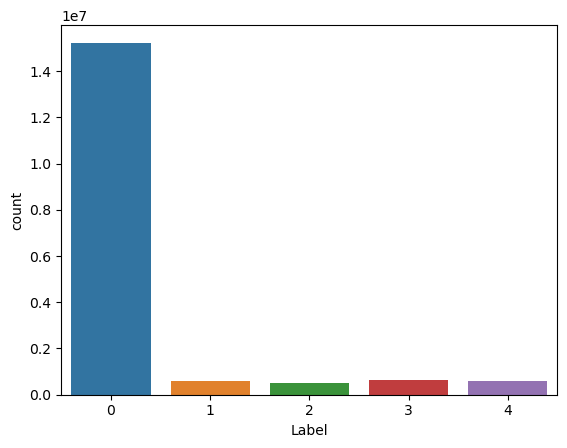

In [19]:

log.info("#####################################")
log.info("Running dataset: [All]")
log.info("#####################################")
precision = []
recall = []
f1_score = []
support = []
results =[]
data=[]
metrics=[]
values=[]

dataPath=appconfig.getconfig_from_keys(["data_path","all"])  
print(f"Datapath: {dataPath}")
combined_df = pd.read_csv(dataPath)

X, y = PreprocessData(combined_df)


In [20]:

# Cross-validation and SMOTE
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
smote = SMOTE(random_state=42)

for model_name in train_models:
    print('-------------------------------')
    print('Model: ', model_name)
    print('-------------------------------')
    
    precision_scores = []
    recall_scores = []
    f1_scores = []
    support_scores = []
    
    for train_index, test_index in skf.split(X, y):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Apply SMOTE
        x_train, y_train = smote.fit_resample(x_train, y_train)

        if model_name == 'SVC':
            start_ts, formatted_start_ts = getDate()
            log.info("Starting SVC model...[%s]", formatted_start_ts)
            y_pred, training_score, testing_score = alg.SVC_Scan(x_train, y_train, x_test, y_test)
            end_ts, formatted_end_ts = getDate()
            log.info('SVC model finished. Elapsed time: %s', end_ts - start_ts)
        elif model_name == 'LOGR':
            start_ts, formatted_start_ts = getDate()
            log.info("Starting Logistic Regression model...[%s]", formatted_start_ts)
            y_pred, training_score, testing_score = alg.Logistic_regression_Scan(x_train, y_train, x_test, y_test)
            end_ts, formatted_end_ts = getDate()
            log.info('Logistic Regression model finished. Elapsed time: %s', end_ts - start_ts)
        elif model_name == 'MLP':
            start_ts, formatted_start_ts = getDate()
            log.info("Starting MLP model...[%s]", formatted_start_ts)
            y_pred, training_score, testing_score = alg.MLP_Scan(x_train, y_train, x_test, y_test)
            end_ts, formatted_end_ts = getDate()
            log.info('MLP model finished. Elapsed time: %s', end_ts - start_ts)
        elif model_name == 'SGD':
            start_ts, formatted_start_ts = getDate()
            log.info("Starting SGD model...[%s]", formatted_start_ts)
            y_pred, training_score, testing_score = alg.SGD_Scan(x_train, y_train, x_test, y_test)
            end_ts, formatted_end_ts = getDate()
            log.info('SGD model finished. Elapsed time: %s', end_ts - start_ts)
        elif model_name == 'LRG':
            start_ts, formatted_start_ts = getDate()
            log.info("Starting Linear Regression model...[%s]", formatted_start_ts)
            y_pred, training_score, testing_score = alg.Linear_regression_Scan(x_train, y_train, x_test, y_test)
            end_ts, formatted_end_ts = getDate()
            log.info('Linear Regression model finished. Elapsed time: %s', end_ts - start_ts)
        elif model_name == 'CNN':
            start_ts, formatted_start_ts = getDate()
            log.info("Starting CNN model...[%s]", formatted_start_ts)
            y_pred, training_score, testing_score = alg.CNN_Scan(x_train, y_train, x_test, y_test)
            end_ts, formatted_end_ts = getDate()
            log.info('CNN model finished. Elapsed time: %s', end_ts - start_ts)
        
        print(f"--Report for "+model_name+"--")
        print(classification_report(y_test, y_pred, zero_division=1))
        precision_score, recall_score, f1_score_val, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=1)
        support_score = (pd.Series(y_pred).value_counts() / len(y_pred)).loc[0]
        
        precision_scores.append(precision_score)
        recall_scores.append(recall_score)
        f1_scores.append(f1_score_val)
        support_scores.append(support_score)

    precision.append(nmp.mean(precision_scores))
    recall.append(nmp.mean(recall_scores))
    f1_score.append(nmp.mean(f1_scores))
    support.append(nmp.mean(support_scores))

    data.append([model_name, nmp.mean(training_score), nmp.mean(testing_score)])

col_names = ["Model", "Train Score", "Test Score"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

metrics = ['Precision', 'Recall', 'F1 Score', 'Support']
values = [precision, recall, f1_score, support]
PlotBarGraph(train_models, metrics, values, 'Metrics by dataset - All dataset', 'Models', 'Score')
        

-------------------------------
Model:  LOGR
-------------------------------


c:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--Report for LOGR--
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3045365
           1       1.00      1.00      1.00    117504
           2       1.00      1.00      1.00     98370
           3       1.00      1.00      1.00    130979
           4       1.00      1.00      1.00    119450

    accuracy                           1.00   3511668
   macro avg       1.00      1.00      1.00   3511668
weighted avg       1.00      1.00      1.00   3511668

Loading existing LOGR model...
LOGR Model loaded successfully.
--Report for LOGR--
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   3045365
           1       1.00      1.00      1.00    117504
           2       1.00      1.00      1.00     98369
           3       1.00      1.00      1.00    130980
           4       1.00      1.00      1.00    119450

    accuracy                           1.00   3511668
   macro avg       1.00     

c:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MemoryError: Unable to allocate 45.4 GiB for an array with shape (60907290, 100) and data type float64